#### Модель on TEST (strict)

In [39]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import joblib
import warnings

# Настройки
warnings.filterwarnings('ignore')

# Загрузка данных (используем ваш обработанный файл)
labeled_data = pd.read_csv('data/processed_labeled_comments.csv')

# Подготовка данных
X = labeled_data['comment']
y = labeled_data[['Нравится скорость отработки заявок', 
                 'Нравится качество выполнения заявки', 
                 'Нравится качество работы сотрудников', 
                 'Понравилось выполнение заявки', 
                 'Вопрос решен']]

# Проверка распределения классов
print("Распределение по классам:")
print(y.sum())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Создание пайплайна с TfidfVectorizer и классификатором
def build_model(classifier):
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            stop_words=list(stop_words),  # Преобразуем множество в список
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.9
        )),
        ('clf', MultiOutputClassifier(classifier, n_jobs=-1))
    ])

# Стоп-слова (преобразуем в список)
stop_words = ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 
             'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же',
             'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от']

# Тестируем разные модели
models = {
    "Random Forest": RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

best_model = None
best_auc = 0

for name, model in models.items():
    print(f"\n=== Обучение модели: {name} ===")
    
    pipeline = build_model(model)
    pipeline.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Отчет по классификации
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=y.columns))
    
    # Расчет ROC-AUC
    print("\nROC-AUC scores:")
    auc_scores = []
    for i, class_name in enumerate(y.columns):
        try:
            auc = roc_auc_score(y_test[class_name], y_pred_proba[i][:, 1])
            auc_scores.append(auc)
            print(f"{class_name}: {auc:.4f}")
        except Exception as e:
            print(f"{class_name}: ошибка вычисления - {str(e)}")
    
    mean_auc = np.mean(auc_scores)
    print(f"\nСредний ROC-AUC: {mean_auc:.4f}")
    
    # Сохраняем лучшую модель
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_model = pipeline
        print(f"Новая лучшая модель: {name} со средним ROC-AUC {best_auc:.4f}")

# Сохранение лучшей модели
if best_model is not None:
    joblib.dump(best_model, 'data/best_comment_classifier.joblib')
    print(f"\nЛучшая модель сохранена в 'data/best_comment_classifier.joblib' со средним ROC-AUC {best_auc:.4f}")

Распределение по классам:
Нравится скорость отработки заявок      223
Нравится качество выполнения заявки      90
Нравится качество работы сотрудников    195
Понравилось выполнение заявки           143
Вопрос решен                            202
dtype: int64

=== Обучение модели: Random Forest ===

Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.88      0.90      0.89        42
 Нравится качество выполнения заявки       1.00      0.53      0.70        15
Нравится качество работы сотрудников       0.85      0.68      0.76        41
       Понравилось выполнение заявки       0.46      0.59      0.52        22
                        Вопрос решен       0.80      0.82      0.81        40

                           micro avg       0.78      0.75      0.77       160
                           macro avg       0.80      0.71      0.74       160
                        weighted avg       0.81    

#### Анализ результатов

Модель успешно загружена. Анализ важности признаков...

Анализ общих важных признаков:

Топ 20 признаков по средней важности:
feature
быстро                0.077457
спасибо               0.069695
оперативно            0.047789
качественно           0.040234
большое               0.023881
вопрос                0.020909
работу                0.019769
мастер                0.018392
очень                 0.017892
оперативность         0.017135
быстро качественно    0.016184
сделали               0.013253
спасибо большое       0.012930
работа                0.012705
сделал                0.012582
большое спасибо       0.012235
проблему              0.011859
аккуратно             0.011572
всё                   0.011413
специалист            0.011166
Name: importance, dtype: float64


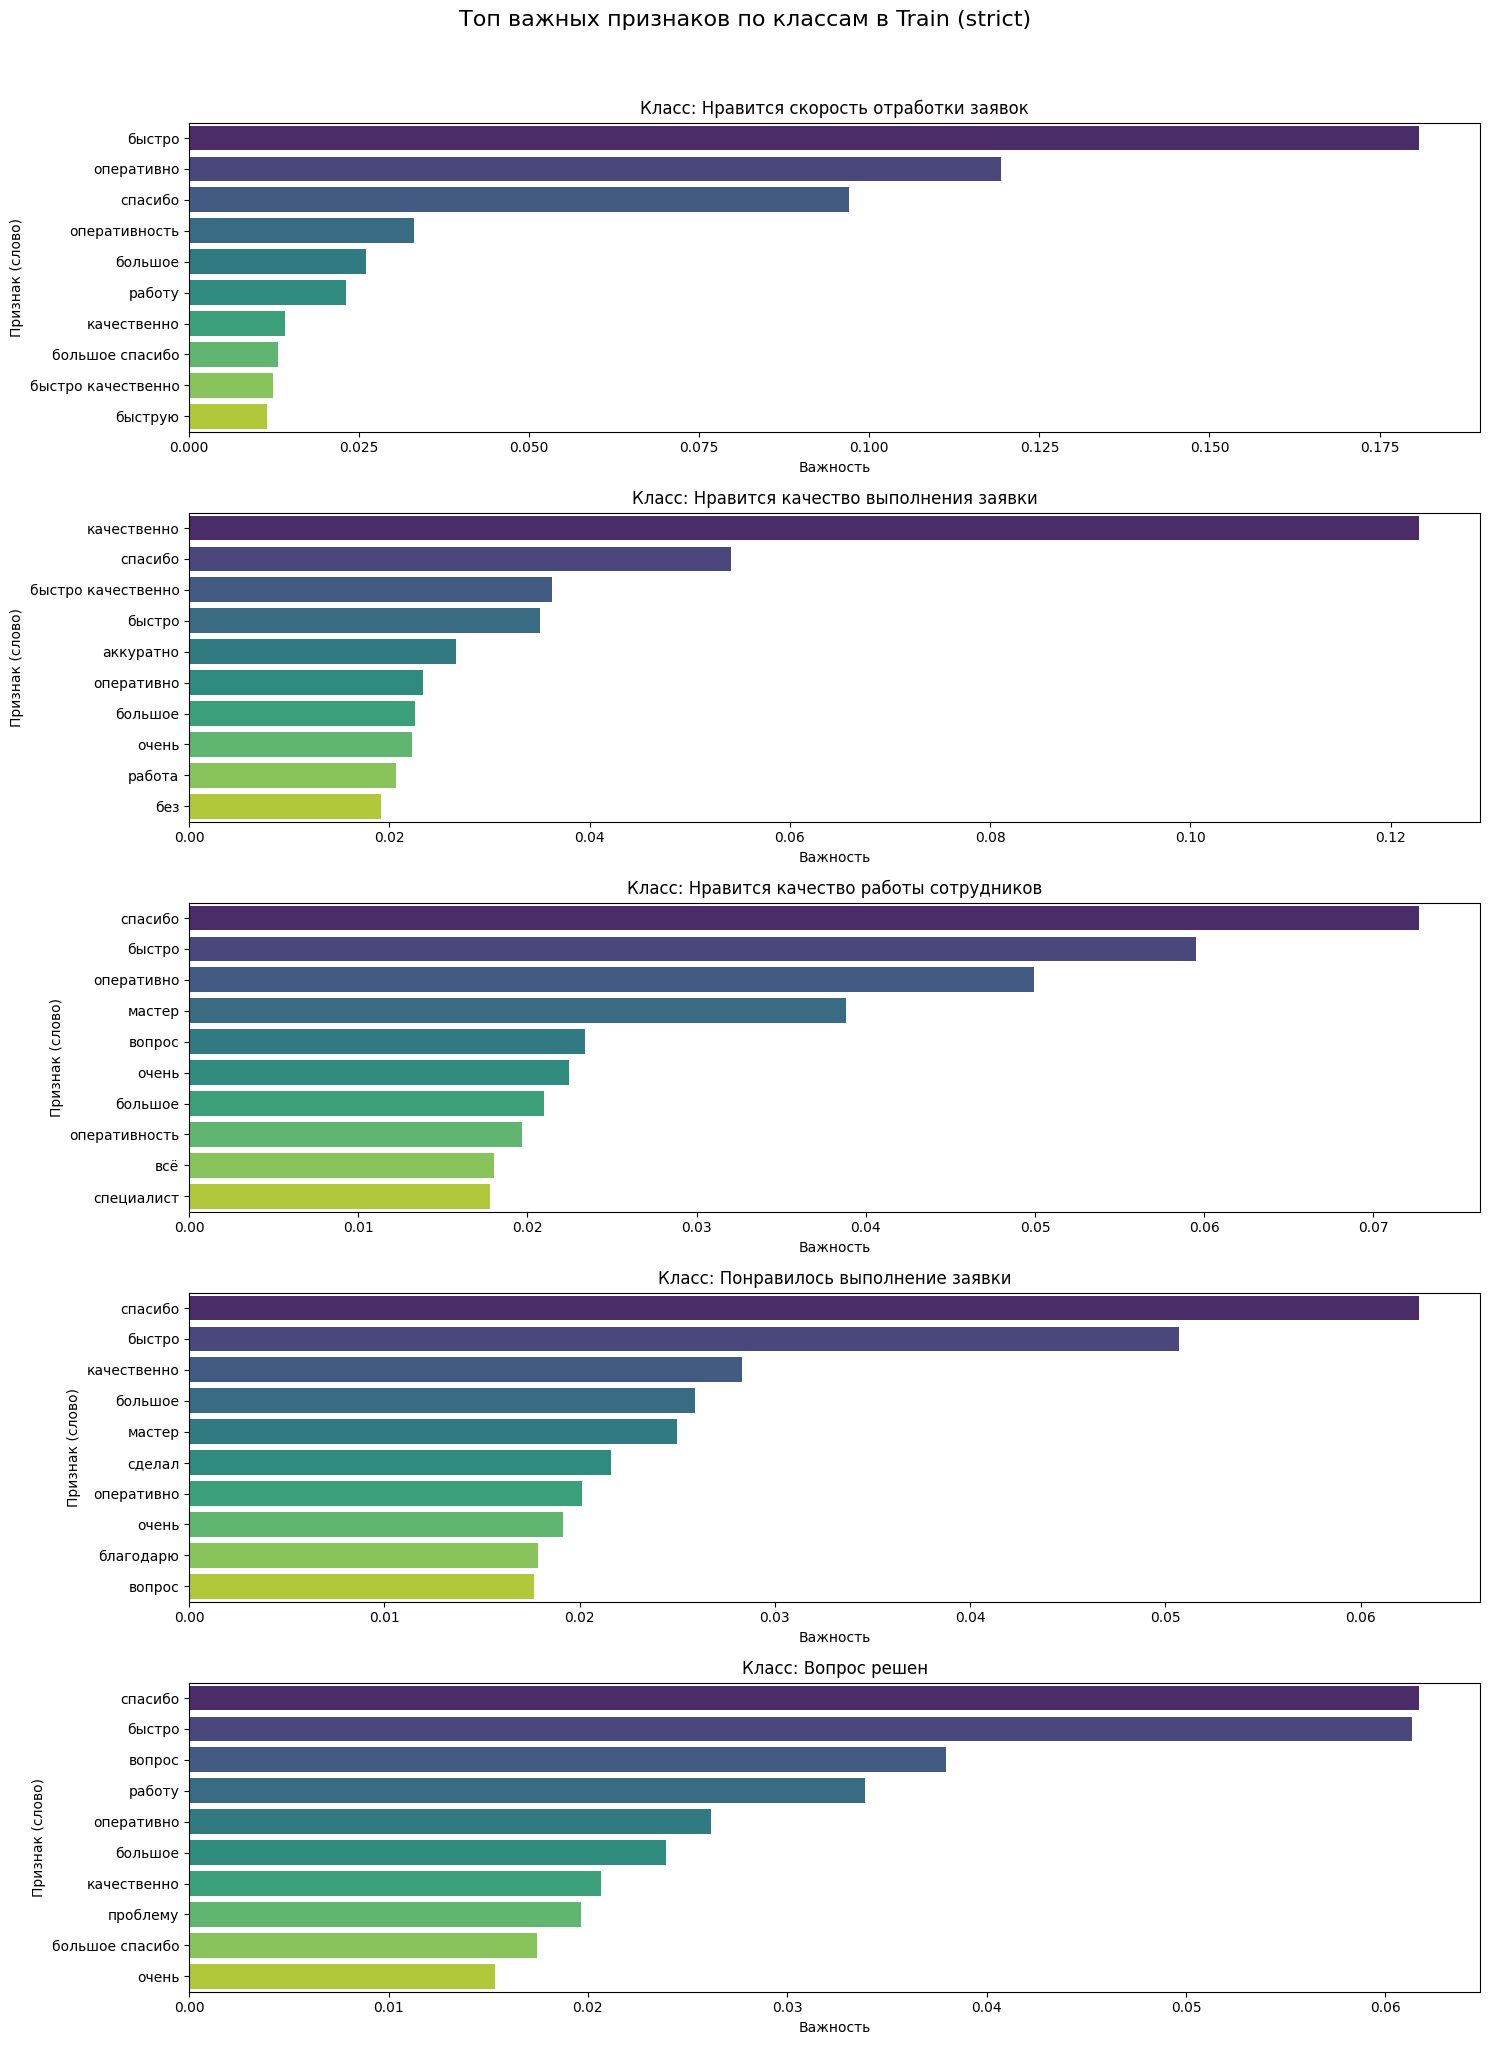

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для анализа и визуализации важности признаков
def analyze_and_visualize_feature_importance(pipeline, class_names, top_n=10):
    """
    Анализирует и визуализирует важность признаков для мультиклассовой модели
    
    Параметры:
    pipeline - обученный пайплайн
    class_names - список названий классов
    top_n - количество топовых признаков для отображения
    """
    # Проверяем, поддерживает ли модель атрибут feature_importances_
    if not hasattr(pipeline.named_steps['clf'].estimators_[0], 'feature_importances_'):
        print("Данный тип модели не поддерживает анализ важности признаков.")
        return
    
    # Получаем названия признаков (слов) из TfidfVectorizer
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    
    # Создаем фигуру для графиков
    plt.figure(figsize=(15, 20))
    plt.suptitle('Топ важных признаков по классам в Train (strict)', y=1.02, fontsize=16)
    
    # Анализируем каждый класс
    for i, class_name in enumerate(class_names):
        # Получаем важность признаков для текущего класса
        importances = pipeline.named_steps['clf'].estimators_[i].feature_importances_
        
        # Создаем DataFrame с важностями
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(top_n)
        
        # Визуализация
        plt.subplot(len(class_names), 1, i+1)
        sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
        plt.title(f'Класс: {class_name}')
        plt.xlabel('Важность')
        plt.ylabel('Признак (слово)')
        plt.tight_layout()
    
    # Дополнительный анализ: общие важные признаки
    print("\nАнализ общих важных признаков:")
    
    # Собираем все важности
    all_importances = []
    for i, class_name in enumerate(class_names):
        importances = pipeline.named_steps['clf'].estimators_[i].feature_importances_
        all_importances.append(pd.DataFrame({
            'feature': feature_names,
            'importance': importances,
            'class': class_name
        }))
    
    all_importances_df = pd.concat(all_importances)
    
    # Находим признаки, которые важны для нескольких классов
    top_features = all_importances_df.groupby('feature')['importance'].mean().sort_values(ascending=False).head(20)
    print("\nТоп 20 признаков по средней важности:")
    print(top_features)

# Определяем названия классов
class_columns = y.columns.tolist()

# Загружаем сохраненную модель (если нужно)
try:
    pipeline = joblib.load('data/best_comment_classifier.joblib')
    print("Модель успешно загружена. Анализ важности признаков...")
    
    # Анализ и визуализация важности признаков
    analyze_and_visualize_feature_importance(pipeline, class_columns)
    
except Exception as e:
    print(f"Ошибка при загрузке модели: {str(e)}")

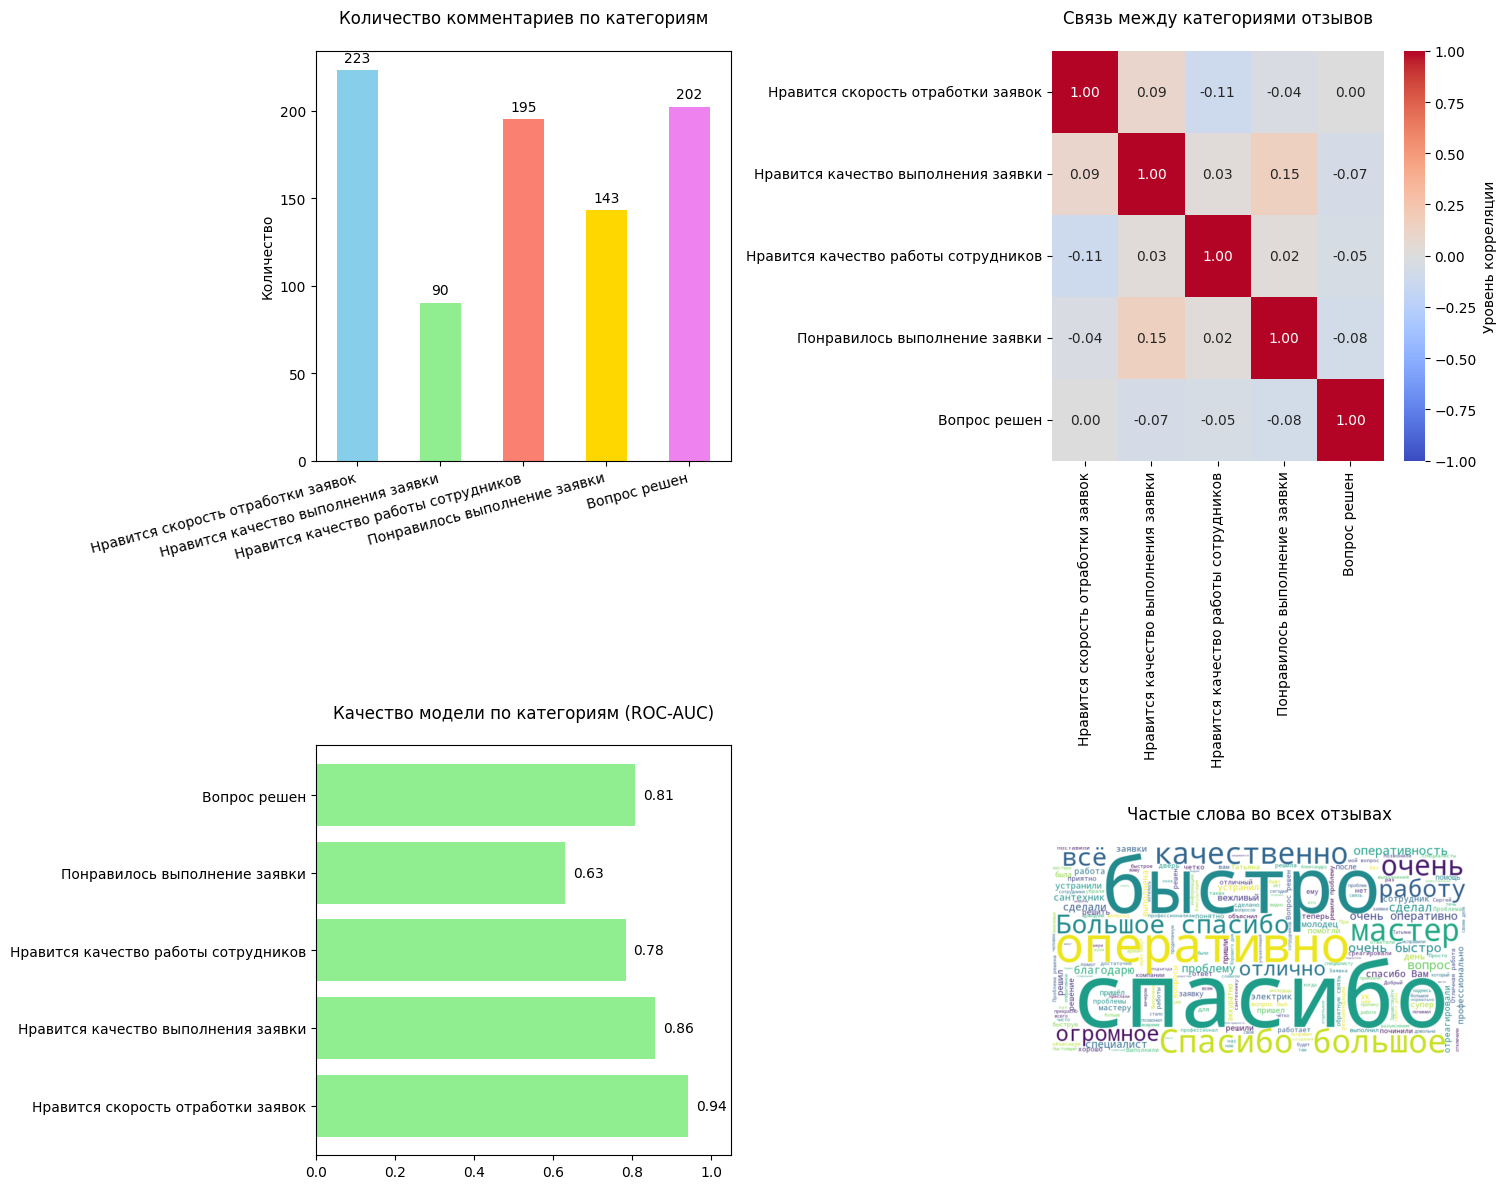


Основные метрики анализа:
Всего комментариев: 320
Средняя длина комментария: 71.0 символов

Распределение по категориям:
Нравится скорость отработки заявок      223
Нравится качество выполнения заявки      90
Нравится качество работы сотрудников    195
Понравилось выполнение заявки           143
Вопрос решен                            202
dtype: int64


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.figure(figsize=(15, 12))

# 1. Распределение классов (упрощенная версия)
plt.subplot(2, 2, 1)
class_counts = y.sum()
class_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold', 'violet'])
plt.title('Количество комментариев по категориям', pad=20)
plt.ylabel('Количество')
plt.xticks(rotation=15, ha='right')

# Добавляем значения над столбцами
for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center')

# 2. Матрица корреляций (более простая)
plt.subplot(2, 2, 2)
corr_matrix = y.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar_kws={'label': 'Уровень корреляции'}, vmin=-1, vmax=1)
plt.title('Связь между категориями отзывов', pad=20)

# 3. ROC-AUC (с понятными комментариями)
plt.subplot(2, 2, 3)
auc_scores = []
categories = []

for i, category in enumerate(y.columns):
    # Проверяем, есть ли оба класса (0 и 1) в тестовых данных
    if y_test[category].nunique() == 2:
        auc = roc_auc_score(y_test[category], best_model.predict_proba(X_test)[i][:, 1])
        auc_scores.append(auc)
        categories.append(category)

if auc_scores:
    bars = plt.barh(categories, auc_scores, color='lightgreen')
    plt.title('Качество модели по категориям (ROC-AUC)', pad=20)
    plt.xlim(0, 1.05)
    
    # Добавляем значения на график
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', va='center')
else:
    plt.text(0.5, 0.5, 'Недостаточно данных\nдля расчета ROC-AUC', 
            ha='center', va='center', fontsize=12)
    plt.title('ROC-AUC не рассчитан', pad=20)

# 4. Облако слов для всех комментариев (простой вариант)
plt.subplot(2, 2, 4)
all_text = ' '.join(X)
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     stopwords=stop_words,
                     colormap='viridis').generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Частые слова во всех отзывах', pad=20)
plt.axis('off')

# Общие настройки
plt.tight_layout()
plt.show()

# Дополнительно: вывод основных метрик
print("\nОсновные метрики анализа:")
print(f"Всего комментариев: {len(X)}")
print(f"Средняя длина комментария: {X.apply(len).mean():.1f} символов")
print("\nРаспределение по категориям:")
print(class_counts)

#### Test on VALID

In [42]:
from tqdm import tqdm  # для прогресс-бара

# Загрузка модели и данных
model = joblib.load('data/best_comment_classifier.joblib')
comments_df = pd.read_csv('data/wide_positive_comments.csv') 
output_file = 'classified_comments_VALID.csv' 

# Функция для классификации и сохранения результатов
def classify_and_save_comments(input_df, output_path, model):
    # Создаем копию DataFrame для результатов, исключая selection_score
    result_df = input_df.copy().drop(columns=['selection_score'], errors='ignore')
    
    # Добавляем колонки для категорий, если их нет
    class_columns = ['Нравится скорость отработки заявок',
                    'Нравится качество выполнения заявки',
                    'Нравится качество работы сотрудников',
                    'Понравилось выполнение заявки',
                    'Вопрос решен']
    
    for col in class_columns:
        if col not in result_df.columns:
            result_df[col] = 0
    
    # Классифицируем каждый комментарий
    for idx, row in tqdm(result_df.iterrows(), total=len(result_df), desc="Классификация"):
        comment = row['comment']
        if pd.isna(comment):
            continue
        
        # Получаем предсказания
        prediction = model.predict([comment])[0]
        probabilities = model.predict_proba([comment])
        
        # Записываем результаты
        for i, col in enumerate(class_columns):
            result_df.at[idx, col] = prediction[i]
            result_df.at[idx, f'Вероятность_{col}'] = probabilities[i][0][1]
    
    # Определяем желаемый порядок столбцов (без selection_score)
    desired_columns = [
        'id',
        'original_rating',
        'comment',
        'Нравится скорость отработки заявок',
        'Нравится качество выполнения заявки',
        'Нравится качество работы сотрудников',
        'Понравилось выполнение заявки',
        'Вопрос решен',
        'Вероятность_Нравится скорость отработки заявок',
        'Вероятность_Нравится качество выполнения заявки',
        'Вероятность_Нравится качество работы сотрудников',
        'Вероятность_Понравилось выполнение заявки',
        'Вероятность_Вопрос решен'
    ]
    
    # Убедимся, что все столбцы существуют в DataFrame
    available_columns = [col for col in desired_columns if col in result_df.columns]
    
    # Переупорядочиваем столбцы (других столбцов кроме desired_columns не будет)
    result_df = result_df[available_columns]
    
    # Сохраняем в новый файл
    result_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    return result_df

# Запускаем классификацию
classified_df = classify_and_save_comments(comments_df, output_file, model)

# Выводим статистику
print("\nРезультаты классификации:")
print(f"Всего комментариев: {len(classified_df)}")
print("Распределение по категориям:")
class_columns = ['Нравится скорость отработки заявок',
                'Нравится качество выполнения заявки',
                'Нравится качество работы сотрудников',
                'Понравилось выполнение заявки',
                'Вопрос решен']
for col in class_columns:
    count = classified_df[col].sum()
    print(f"- {col}: {count} ({count/len(classified_df):.1%})")

# Пример вывода первых 5 строк
print("\nПример классифицированных комментариев:")
display(classified_df.head())

Классификация: 100%|██████████| 1264/1264 [03:34<00:00,  5.89it/s]


Результаты классификации:
Всего комментариев: 1264
Распределение по категориям:
- Нравится скорость отработки заявок: 690 (54.6%)
- Нравится качество выполнения заявки: 153 (12.1%)
- Нравится качество работы сотрудников: 511 (40.4%)
- Понравилось выполнение заявки: 472 (37.3%)
- Вопрос решен: 821 (65.0%)

Пример классифицированных комментариев:


,id,original_rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен,Вероятность_Нравится скорость отработки заявок,Вероятность_Нравится качество выполнения заявки,Вероятность_Нравится качество работы сотрудников,Вероятность_Понравилось выполнение заявки,Вероятность_Вопрос решен
0,2945792,5,спасибо,0,0,0,0,1,0.04,0.006667,0.053333,0.427027,0.946667
1,3234340,5,спасибо!,0,0,0,0,1,0.04,0.006667,0.053333,0.427027,0.946667
2,3380332,5,Отлично,0,0,1,0,1,0.42,0.293333,0.593333,0.368974,0.661256
3,3551430,5,Спасибо,0,0,0,0,1,0.04,0.006667,0.053333,0.427027,0.946667
4,3584536,5,Спасибо за обновление покраски стен,0,0,0,0,1,0.04,0.006667,0.053333,0.427027,0.946667
